# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/cancer-detection
- Data Source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview (Cukierski, 2018)
- Python version: 3.13

## Data Collection and Provenance ##

The data is a subset of the PatchCamelyon (PCam) dataset.

> The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU. (Veeling, 2018)

The subset of data was curated and provided as a kaggel competition. (Cukierski, 2018) We will use the Kaggle Subset of data.

A few important notes about the Kaggle subset include:

> A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. (Cukierski, 2018)

> The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark. (Cukierski, 2018)

## Deep Learning Problem Description ##

**Type of Learning and Task:** This is a **binary image classification** deep learning problem. I will build a **Convolutional Neural Network** deep learning model capable of classifying the images in the data set

**Project Goal:** Build a deep learning model capable of classifying the images with reasonable accuracy.

## Data Description ##

The data is provided as a labeled training set and an unlabeled test set for submission to the Kaggle competition. The data consists of images in the TIFF format. The images have 3 layers (R,G.B) and are 96x96 pixels in size. There are 220,025 images in the labeled training set and 57,458 images in the test set.



In [1]:
#import various libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tifffile
import pathlib
import gc
from sklearn.model_selection import train_test_split

%matplotlib inline

# Exploratory Data Analysis, Visualization, and Cleaning #

## Data Loading ##
We will start by loading the labels and then load each image according to the order of the labels. This will keep the images and labels in sync.

The next three cells are related to running in the Google Collab environment. To run this locally, point DRIVE_PATH to the data directory.



In [2]:
from google.colab import drive
drive.mount('/content/drive')
#DRIVE_PATH = '/content/drive/My Drive/data/cancer_detection'


Mounted at /content/drive


In [3]:
#copy file fro google drive and unzip
!cp '/content/drive/My Drive/data/histopathologic-cancer-detection.zip' '/content/'


In [4]:
!rm -rf '/content/data/'
!unzip -q '/content/histopathologic-cancer-detection.zip' -d '/content/data/'

In [5]:
DRIVE_PATH = '/content/data'

In [6]:
train_labels_df = pd.read_csv(f'{DRIVE_PATH}/train_labels.csv')
train_labels_df.head(10)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [7]:
y_complete = train_labels_df["label"].values
print(y_complete[:10])

[0 1 0 0 0 0 1 1 0 0]


In [8]:
X = []
y = []

for index, row in train_labels_df.iterrows():
    file_id = row['id']
    label = row['label']
    file_name = f'{DRIVE_PATH}/train/{file_id}.tif'

    # Check if the file exists before attempting to read it
    if pathlib.Path(file_name).is_file():
        try:
            img = tifffile.imread(file_name)
            X.append(img)
            y.append(label) # Append label only if image is successfully loaded
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")
    else:
        print(f"File not found: {file_name}")


print(f'len(X): {len(X)}, len(y): {len(y)}')


len(X): 220025, len(y): 220025



## EDA and Visualization ##


In [9]:
def increment_dict(my_dict, my_value):
    if my_dict.get(my_value) is None:
        my_dict[my_value] = 1
    else:
        my_dict[my_value] += 1

layers = {}
width = {}
height = {}
#We need to understand the format of these images. How many layers?
for img_array in X:
    my_shape = img_array.shape
    increment_dict(height, my_shape[0])
    increment_dict(width, my_shape[1])
    increment_dict(layers, my_shape[2])

print(f'height: {height}, width: {width}, layers: {layers}')

height: {96: 220025}, width: {96: 220025}, layers: {3: 220025}


In [10]:
def show_image(img_array, id, label):
    plt.imshow(img_array)
    plt.title(f"Image: {id} - Label: {label}")
    plt.axis('off') # Hide axes for cleaner display
    plt.show()

def show_images(label, count):
    shown = 0
    for i in range(len(y)):
        if y[i] == label:
            shown += 1
            show_image(X[i], train_labels_df.loc[i, 'id'], y[i])
        if shown == count:
            break


**We will display the first three positive label images**

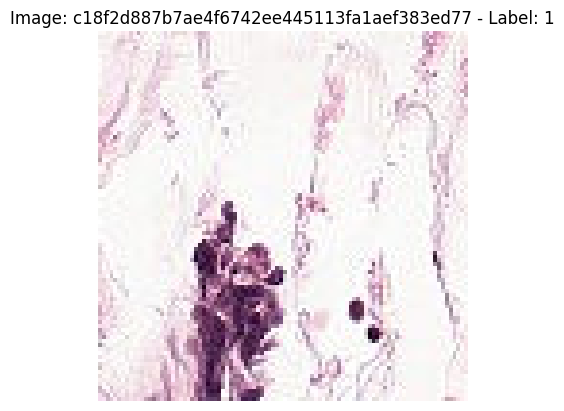

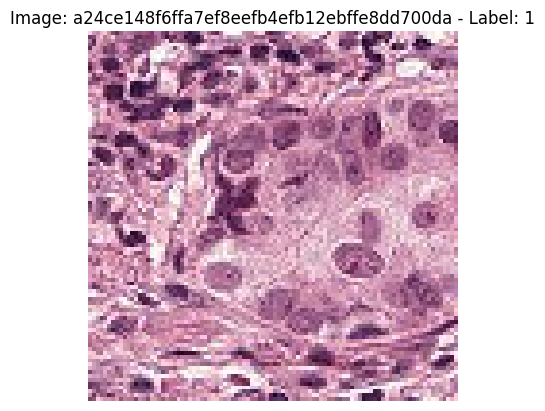

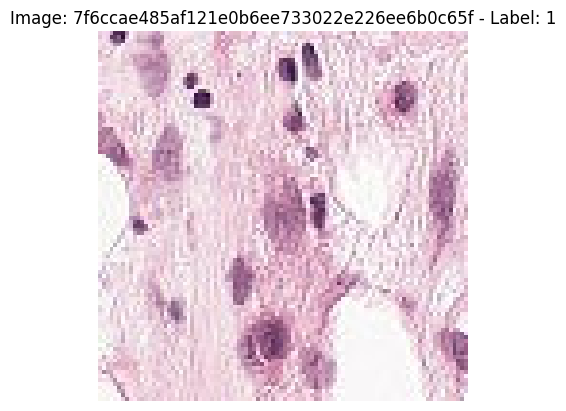

In [11]:
show_images(1, 3)

**And the first three negative label images**

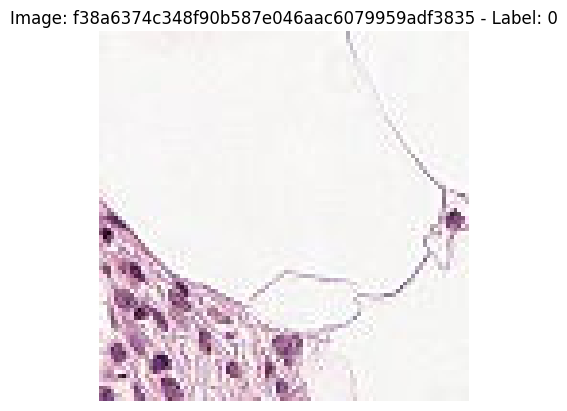

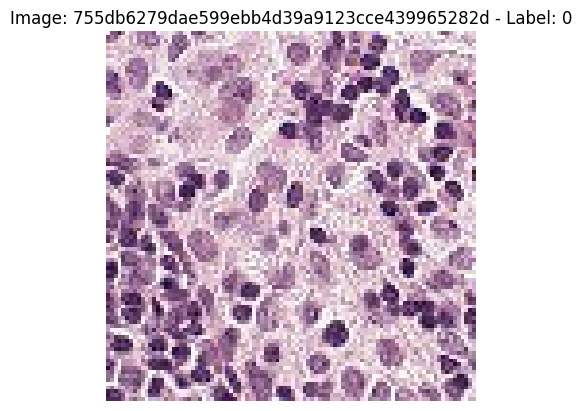

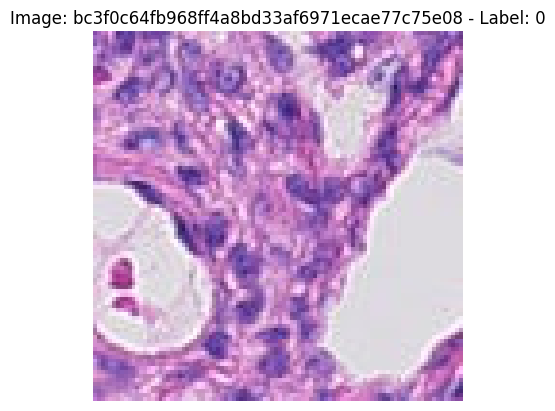

In [12]:
show_images(0, 3)

### Class Distribution ###

As we see below, the classes are imbalanced with the ratio of class 0 to class 1 being approximately 3 to 2.


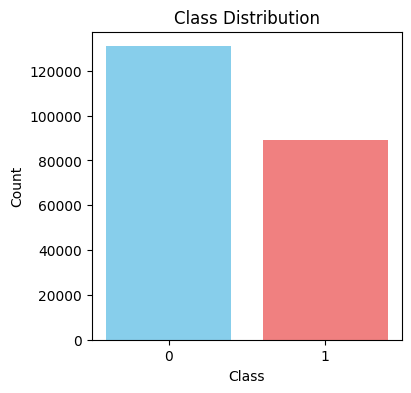

In [13]:
class_0_count = 0
class_1_count = 0

for label in y:
    if label == 0:
        class_0_count += 1
    else:
        class_1_count += 1

plt.figure(figsize=(4, 4))
plt.bar(['0','1'], [class_0_count, class_1_count], color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

### Distribution of Average and Standard Deviation for RGB ###
Let's examine the distribution of average and standard deviation of pixel values in the three layers (R,G,B)


In [14]:
class_0_r_avgs = []
class_0_g_avgs = []
class_0_b_avgs = []
class_1_r_avgs = []
class_1_g_avgs = []
class_1_b_avgs = []

class_0_r_stds = []
class_0_g_stds = []
class_0_b_stds = []
class_1_r_stds = []
class_1_g_stds = []
class_1_b_stds = []

def avg_per_layer(img_array):
    """"
    returns the average value of the R, G. B layers
    for an image
    """
    return np.mean(img_array, axis=(0,1))

def std_per_layer(img_array):
    """"
    returns the standard deviation value of the R, G. B layers
    for an image
    """
    return np.std(img_array, axis=(0,1))


for i in range(len(X)):
    img_array = X[i]
    label = y[i]
    r_avg, g_avg, b_avg = avg_per_layer(img_array)
    r_std, g_std, b_std = std_per_layer(img_array)
    if label == 0:
        class_0_r_avgs.append(r_avg)
        class_0_b_avgs.append(b_avg)
        class_0_g_avgs.append(g_avg)
        class_0_r_stds.append(r_std)
        class_0_b_stds.append(b_std)
        class_0_g_stds.append(g_std)
    else:
        class_1_r_avgs.append(r_avg)
        class_1_b_avgs.append(b_avg)
        class_1_g_avgs.append(g_avg)
        class_1_r_stds.append(r_std)
        class_1_b_stds.append(b_std)
        class_1_g_stds.append(g_std)


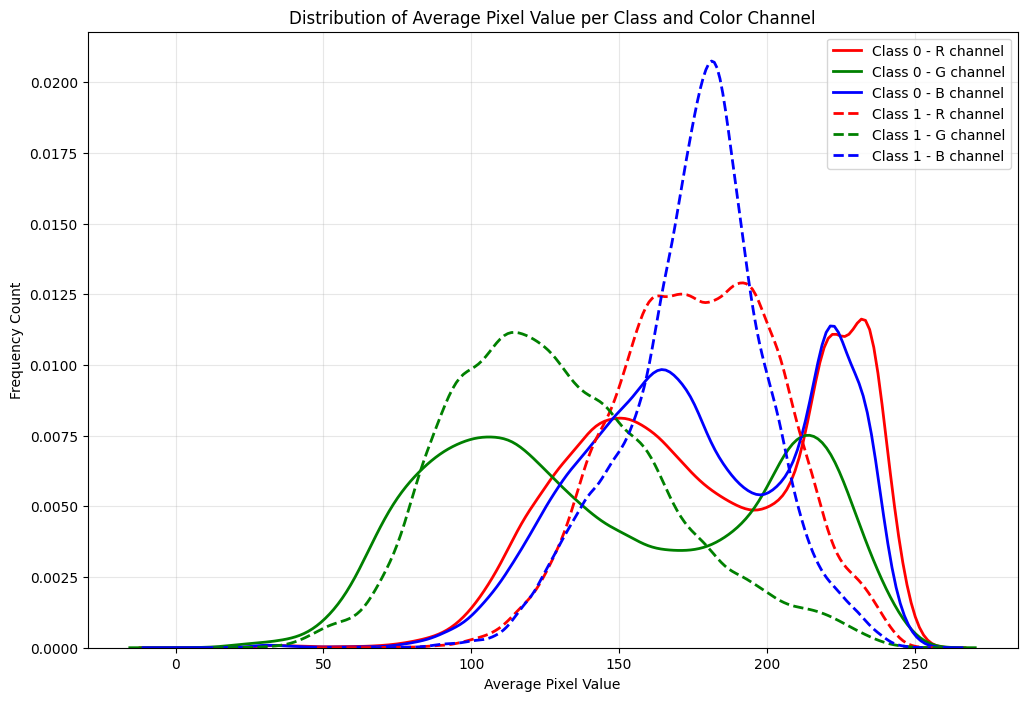

In [15]:
plt.figure(figsize=(12, 8))
sns.kdeplot(class_0_r_avgs, label='Class 0 - R channel', color='red', linestyle='-', linewidth=2)
sns.kdeplot(class_0_g_avgs, label='Class 0 - G channel', color='green', linestyle='-', linewidth=2)
sns.kdeplot(class_0_b_avgs, label='Class 0 - B channel', color='blue', linestyle='-', linewidth=2)
sns.kdeplot(class_1_r_avgs, label='Class 1 - R channel', color='red', linestyle='--', linewidth=2)
sns.kdeplot(class_1_g_avgs, label='Class 1 - G channel', color='green', linestyle='--', linewidth=2)
sns.kdeplot(class_1_b_avgs, label='Class 1 - B channel', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency Count')
plt.title('Distribution of Average Pixel Value per Class and Color Channel')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

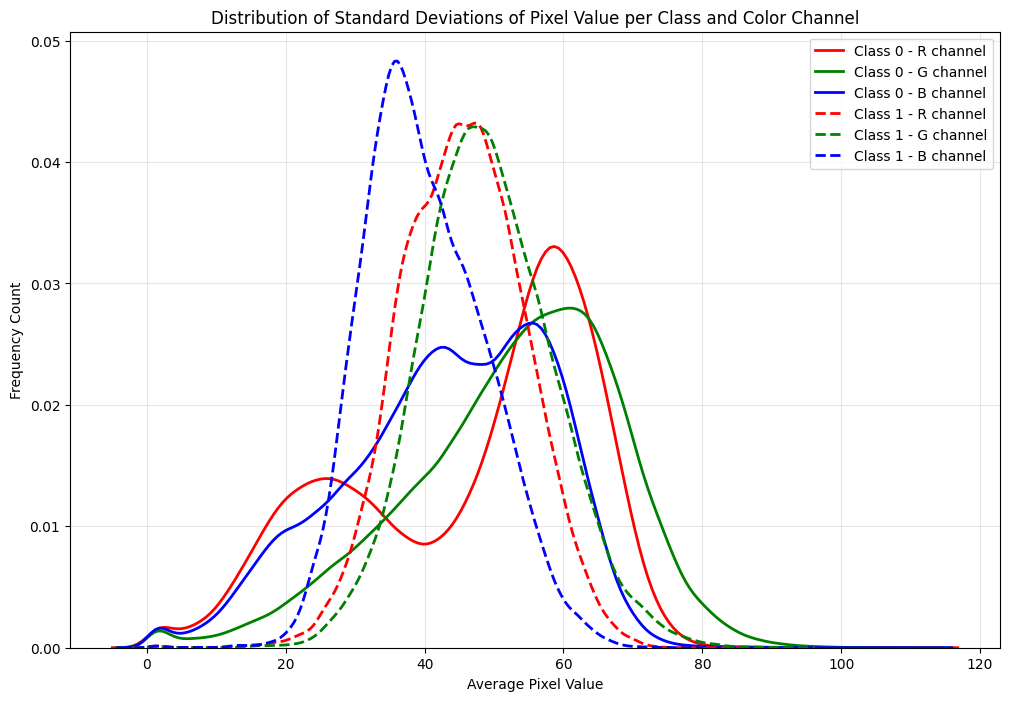

In [16]:
plt.figure(figsize=(12, 8))
sns.kdeplot(class_0_r_stds, label='Class 0 - R channel', color='red', linestyle='-', linewidth=2)
sns.kdeplot(class_0_g_stds, label='Class 0 - G channel', color='green', linestyle='-', linewidth=2)
sns.kdeplot(class_0_b_stds, label='Class 0 - B channel', color='blue', linestyle='-', linewidth=2)
sns.kdeplot(class_1_r_stds, label='Class 1 - R channel', color='red', linestyle='--', linewidth=2)
sns.kdeplot(class_1_g_stds, label='Class 1 - G channel', color='green', linestyle='--', linewidth=2)
sns.kdeplot(class_1_b_stds, label='Class 1 - B channel', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency Count')
plt.title('Distribution of Standard Deviations of Pixel Value per Class and Color Channel')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Data Cleaning ##
### Outlier Detection and Removal ###

We will create box plot to visualize outliers.

<Figure size 1600x700 with 0 Axes>

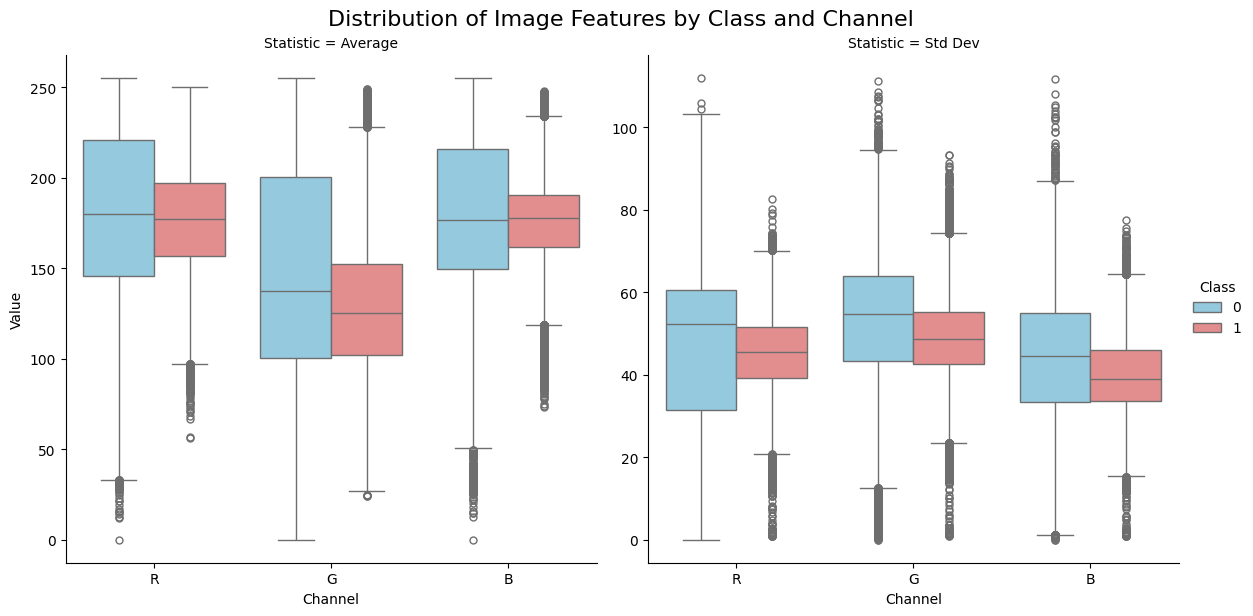

In [17]:
# Determine the length of the sample lists for easier calculation
len_c0 = len(class_0_r_avgs)
len_c1 = len(class_1_r_avgs)
total_len = (len_c0 + len_c1) * 3

# Combine Averages
data_avg = {
    'Value': class_0_r_avgs + class_0_g_avgs + class_0_b_avgs +
             class_1_r_avgs + class_1_g_avgs + class_1_b_avgs,
    'Channel': (['R'] * len_c0) + (['G'] * len_c0) + (['B'] * len_c0) +
               (['R'] * len_c1) + (['G'] * len_c1) + (['B'] * len_c1),
    'Class': ([0] * (len_c0 * 3)) + ([1] * (len_c1 * 3)),
    'Statistic': ['Average'] * total_len
}
df_avg = pd.DataFrame(data_avg)

# Combine Standard Deviations
data_std = {
    'Value': class_0_r_stds + class_0_g_stds + class_0_b_stds +
             class_1_r_stds + class_1_g_stds + class_1_b_stds,
    'Channel': data_avg['Channel'],
    'Class': data_avg['Class'],
    'Statistic': ['Std Dev'] * total_len
}
df_std = pd.DataFrame(data_std)

df_combined = pd.concat([df_avg, df_std])

plt.figure(figsize=(16, 7))

# Use seaborn's catplot for a faceted grid of box plots
sns.catplot(data=df_combined, x='Channel', y='Value', hue='Class',
    col='Statistic', kind='box', palette=['skyblue', 'lightcoral'],
    sharey=False, height=6, aspect=1)

plt.suptitle('Distribution of Image Features by Class and Channel', y=1.02, fontsize=16)
plt.show()


**These boxplots confirm we have outliers.**

### IQR Outlier Detection ###

Then we will use the **Interquartile Range (IQR) method**, which is "one of the most robust and widely used techniques for detecting outliers — especially in skewed distributions." (More, 2025)


In [18]:
data_c0 = {
    'R_Avg': class_0_r_avgs, 'G_Avg': class_0_g_avgs, 'B_Avg': class_0_b_avgs,
    'R_Std': class_0_r_stds, 'G_Std': class_0_g_stds, 'B_Std': class_0_b_stds,
    'Class': 0
}
df_c0 = pd.DataFrame(data_c0)

data_c1 = {
    'R_Avg': class_1_r_avgs, 'G_Avg': class_1_g_avgs, 'B_Avg': class_1_b_avgs,
    'R_Std': class_1_r_stds, 'G_Std': class_1_g_stds, 'B_Std': class_1_b_stds,
    'Class': 1
}
df_c1 = pd.DataFrame(data_c1)

df_features = pd.concat([df_c0, df_c1], ignore_index=True)

def find_iqr_outliers(df, feature_name):
    """
    Calculates IQR bounds and returns a boolean Series indicating outliers.
    """
    #Calculate Q1, Q3, and IQR
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    #Define Bounds (1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Return a boolean Series where True indicates an outlier
    return (df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)

df_outliers = pd.DataFrame(index=df_features.index)

feature_columns = ['R_Avg', 'G_Avg', 'B_Avg', 'R_Std', 'G_Std', 'B_Std']

for class_label in [0, 1]:

    df_class = df_features[df_features['Class'] == class_label]

    for feature in feature_columns:
        # Generate a unique column name for the flag (e.g., 'R_Avg_C0_Outlier')
        flag_col = f'{feature}_C{class_label}_Outlier'

        # Calculate flags and assign them back to the main df_outliers
        df_outliers.loc[df_class.index, flag_col] = find_iqr_outliers(df_class, feature)

pd.set_option('future.no_silent_downcasting', True)
df_outliers = df_outliers.fillna(False)

#Outliers in AVG Features (R_Avg, G_Avg, B_Avg)
avg_outlier_flags = df_outliers[[col for col in df_outliers.columns if 'Avg' in col]]
avg_outlier_count = avg_outlier_flags.sum(axis=1)

#Outliers in STD DEV Features (R_Std, G_Std, B_Std)
std_outlier_flags = df_outliers[[col for col in df_outliers.columns if 'Std' in col]]
std_outlier_count = std_outlier_flags.sum(axis=1)

# Total number of features flagged as an outlier for each image (max of 6)
total_outlier_count = avg_outlier_count + std_outlier_count

# Outliers in ONLY ONE channel/feature
single_feature_outliers = (total_outlier_count == 1).sum()

# Outliers in ALL THREE CHANNELS (Avg and Std separately)
all_avg_outliers = (avg_outlier_count == 3).sum()
all_std_outliers = (std_outlier_count == 3).sum()

# Outlier in ALL SIX features (R,G,B Avg AND R,G,B Std)
all_six_features_outliers = (total_outlier_count == 6).sum()


print("IQR Outlier Summary")
print(f"Total Images Analyzed: {len(df_features)}")

print("Outliers based on Total Flags (Avg + Std Dev)")
print(f"Images flagged as outlier in ONLY ONE feature (outlier count = 1): {single_feature_outliers}")
print(f"Images flagged as outlier in ALL SIX features (outlier count = 6): {all_six_features_outliers}")

print("Outliers based on Average Features Only")
print(f"Images flagged as outlier in ALL THREE AVERAGE features (R, G, and B): {all_avg_outliers}")

print("Outliers based on STD Features Only")
print(f"Images flagged as outlier in ALL THREE STD features (R, G, and B): {all_std_outliers}")

total_images_with_outliers = (total_outlier_count > 0).sum()
print(f"Total Images flagged as outlier in AT LEAST ONE feature: {total_images_with_outliers}")

IQR Outlier Summary
Total Images Analyzed: 220025
Outliers based on Total Flags (Avg + Std Dev)
Images flagged as outlier in ONLY ONE feature (outlier count = 1): 3426
Images flagged as outlier in ALL SIX features (outlier count = 6): 0
Outliers based on Average Features Only
Images flagged as outlier in ALL THREE AVERAGE features (R, G, and B): 4
Outliers based on STD Features Only
Images flagged as outlier in ALL THREE STD features (R, G, and B): 182
Total Images flagged as outlier in AT LEAST ONE feature: 4609


**Only ~2%** of the data contained and outlier. We will **remove all images containing outliers** from the training data set.

In [19]:
indices_to_keep = total_outlier_count[total_outlier_count == 0].index.tolist()
X_cleaned = [X[i] for i in indices_to_keep]
y_cleaned = [y[i] for i in indices_to_keep]

print(f'X_cleaned: {len(X_cleaned)}, y_cleaned: {len(y_cleaned)}')

X_cleaned: 215416, y_cleaned: 215416


### Sampling and Normalizing the Data ###

The data set is too large to conduct hyperparameter tuning on the entire set, so I will select a subset of 10,000 random samples and then, we will normalize it to a range of 0-1 (rather than the current 0-255). We will also extract a validation set from the training data for use in monitoring model training.

For final training on the entire data set, we will use a data generator approach and normalize as the data is loaded.

Now split a **subset** of the data into **training and validation** sets for hyperparameter tuning

In [20]:
from imblearn.under_sampling import RandomUnderSampler

# Convert to NumPy array for consistency, then delete the source structure.
X_cleaned_np = np.array(X_cleaned)

print(f"Initial shape: {X_cleaned_np.shape}, dtype: {X_cleaned_np.dtype}")

#We will start by taking a random subsample of 20K,
#then we will use RandomUnderSampler to balance the classes
SUBSET_SIZE = 15000
subset_ratio = SUBSET_SIZE / len(X_cleaned_np)

# Use train_test_split on the uint8 data to get the stratified subset.
# The 'test' output will be our 15,000-sample subset.
X_junk, X_subset_all, y_junk, y_subset_all = train_test_split(
    X_cleaned_np, y_cleaned,
    test_size=subset_ratio,
    random_state=42,
    stratify=y_cleaned,
    shuffle=True
)

print(f'X_subset_all: {len(X_subset_all)}, y_subset_all: {len(y_subset_all)}')

n_samples = X_subset_all.shape[0]

#the X data has to be flattened before resampling
X_subset_2d = X_subset_all.reshape(n_samples, -1)

print(f"Flattened X shape: {X_subset_2d.shape}")

rus = RandomUnderSampler(random_state=42)
# Use the new 2D array for resampling
X_resampled_2d, y_resampled = rus.fit_resample(X_subset_2d, y_subset_all)

print(f'X_resampled_2d: {len(X_resampled_2d)}, y_resampled: {len(y_resampled)}')

#Reshape back to (96, 96, 3)
X_resampled = X_resampled_2d.reshape(-1, 96, 96, 3)

# normalize only the small subset to float32.
# converting from uint8 to float32 is expensive in terms of RAM usage
X_resampled = np.divide(X_resampled, 255.0, dtype=np.float32)

print(f'X_resampled: {len(X_resampled)}, y_resampled: {len(y_resampled)}')

# split the small, normalized subset into train/val splits for tuning.
X_subset, X_val, y_subset, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f'X_subset: {len(X_subset)}, X_val: {len(X_val)}, y_subset: : {len(y_subset)}, y_val: : {len(y_val)}')


Initial shape: (215416, 96, 96, 3), dtype: uint8
X_subset_all: 15000, y_subset_all: 15000
Flattened X shape: (15000, 27648)
X_resampled_2d: 12152, y_resampled: 12152
X_resampled: 12152, y_resampled: 12152
X_subset: 9721, X_val: 2431, y_subset: : 9721, y_val: : 2431


In [23]:
#clean up unused data

#DO NOT delete indices_to_keep we need that later

del class_0_r_avgs
del class_0_g_avgs
del class_0_b_avgs
del class_1_r_avgs
del class_1_g_avgs
del class_1_b_avgs

del class_0_r_stds
del class_0_g_stds
del class_0_b_stds
del class_1_r_stds
del class_1_g_stds
del class_1_b_stds

del data_avg
del df_avg
del data_std
del df_std
del df_combined

del data_c0
del df_c0
del data_c1
del df_c1
del df_features

del df_outliers
del avg_outlier_flags
del avg_outlier_count
del std_outlier_flags
del std_outlier_count
del total_outlier_count
del single_feature_outliers
del all_avg_outliers
del all_std_outliers
del all_six_features_outliers

del X, train_labels_df

del X_resampled
del X_subset_all
del y_subset_all

del X_subset_2d
del X_resampled_2d
del X_cleaned
del X_cleaned_np
del X_junk
del y_junk

gc.collect()


NameError: name 'class_0_r_avgs' is not defined

# Analysis (Model Building and Training) #

Because the data documentation indicates that the label is based on the central 32x32 pixels, we will use a Keras cropping layer at the beginning to focus our model's attention. We will increase our number of filters with each iteration because "Increasing the number of feature maps can help the network learn more complex and abstract features." (Baeldung, 2023)

## Plan of Analysis ##

Architecture 1:
- Crop to 32x32
- Convolution, Convolution, MaxPool pattern repeated 4 times
- padding = same because we already cropped the image
- filter depth: 32, 64, 128, 256
- Dense Hidden Layers: 128, 64, 32, 16, 8
- Filter Size: 3x3
- Pooling: Max
- Hidden Layers: Relu
- Output: Sigmoid

In initial testing, Architecture 1 was found to **perform poorly**, so architecture 2 attempts to address that by **removing the cropping layer**. It may be that many tumors lay on the boundary of the central 32x32 pixels and cropping made it difficult to identify them.

Architecture 2:
- NO Cropping
- Convolution, Convolution, MaxPool pattern repeated 4 times
- padding = same because we already cropped the image
- filter depth: 32, 64, 128, 256
- Dense Hidden Layers: 128, 64, 32, 16, 8
- Filter Size: 3x3
- Pooling: Max
- Hidden Layers: Relu
- Output: Sigmoid

Archtecture 2 still performed poorly. Adding dropout and normalization can help (Litjens, 2019), so I will try that for architecture 3

Architecture 3:
- No Cropping
- Convolution, Convolution, MaxPool, Dropout pattern repeated 4 times
- padding = same because we already cropped the image
- filter depth: 32, 64, 128, 256
- Dense Hidden Layers: 128, 64, 16
- Hidden Layers: Relu
- Output: Sigmoid

HyperParameters:
- Learning rate: 0.01, 0.001, 0.0001
- Epochs: 20, 50 (I want to keep these shorter during the grid search for hyperparameters)
- Optimization Method: Adam, RMSProp
- dropout rate: (added for architecture 2) 0.3, 0.4, 0.5

I expect architecture 1 will do well because the repeated pattern of Convolution, Convolution, Max Pooling has shown to perform well on image classification tasks.

I expect architecture 2 to reduce overfitting

I expect architecture 3 to improve accuracy without increasing overfitting


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras as keras # Need for optimizer definition
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [53]:

def create_architecture_1(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam'):
    """
    Creates architecture 1
    """
    model = models.Sequential()

    #Cropping the 96x96 image down to the central 32x32 region.
    model.add(layers.Cropping2D(cropping=((32, 32), (32, 32)), input_shape=input_shape))
    filters = initial_filters
    for i in range(4): # Loop 4 times (Conv, Conv, MaxPool
        # Increase filters: 32, 64, 128, 256
        filters = (i+1)*initial_filters
        # Conv2D Layer 1: 3x3, Relu, padding='same' (maintains size before pooling)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # Conv2D Layer 2: 3x3, Relu, padding='same'
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # MaxPool2D Layer
        model.add(layers.MaxPool2D(pool_size=(2, 2)))
    # Classifier Head
    model.add(layers.Flatten())
    # Dense Hidden Layers: 128, 64, 32, 16, 8 (all Relu)
    for units in [128, 64, 32, 16, 8]:
        model.add(layers.Dense(units, activation='relu'))
    # Output Layer: 1 unit, Sigmoid
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer based on the hyperparameter search
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile the model for binary classification
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_architecture_2(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    """
    Creates architecture 2
    """
    model = models.Sequential()

    #NO Cropping
    filters = initial_filters
    for i in range(4): # Loop 4 times (Conv, Conv, MaxPool
        # Increase filters: 32, 64, 128, 256
        filters = (i+1)*initial_filters
        # Conv2D Layer 1: 3x3, Relu, padding='same' (maintains size before pooling)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # Conv2D Layer 2: 3x3, Relu, padding='same'
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # MaxPool2D Layer
        model.add(layers.MaxPool2D(pool_size=(2, 2)))
    # Classifier Head
    model.add(layers.Flatten())
    # Dense Hidden Layers: 128, 64, 32, 16, 8 (all Relu)
    for units in [128, 64, 32, 16, 8]:
        model.add(layers.Dense(units, activation='relu'))
    # Output Layer: 1 unit, Sigmoid
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer based on the hyperparameter search
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile the model for binary classification
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_architecture_3(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    """
    Creates architecture 3
    """
    model = models.Sequential()
    filters = initial_filters
    for i in range(4):  # 4 Conv blocks
        filters = (i + 1) * initial_filters

        # First Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Second Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Pooling and Dropout
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if i >= 1:  # light dropout after deeper blocks
            model.add(layers.Dropout(dropout_rate))

    # Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Simpler Dense head
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Optimizer selection
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_architecture_4(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    """
    Creates architecture 4
    """
    model = models.Sequential()
    filters = initial_filters
    for i in range(4):  # 4 Conv blocks
        filters = (i + 1) * initial_filters

        # First Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Second Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Pooling and Dropout
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if i >= 1:  # light dropout after deeper blocks
            model.add(layers.Dropout(dropout_rate))

    # Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Simpler Dense head
    model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Optimizer selection
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_model(model_name, input_shape=(96, 96, 3), learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    if model_name == 'architecture_1':
        return create_architecture_1(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name)
    elif model_name == 'architecture_2':
        return create_architecture_2(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout_rate=dropout_rate)
    elif model_name == 'architecture_3':
        return create_architecture_3(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout_rate=dropout_rate)
    elif model_name == 'architecture_4':
        return create_architecture_4(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout_rate=dropout_rate)
    else:
      raise ValueError(f"Unknown model name: {model_name}")


def hyperparameter_grid_search(model_name, hyperparameter_grid, X_subset_tensor,
                               y_subset_tensor, X_val_tensor, y_val_tensor, batch_size=64):

    print(f"Starting Hyperparameter Search on a training subset of {len(X_subset)} images.")
    results = []
    #Run the Grid Search Loop
    for lr in hyperparameter_grid['learning_rate']:
        for optimizer in hyperparameter_grid['optimizer_name']:
            for epochs in hyperparameter_grid['epochs']:
                for dropout_rate in hyperparameter_grid['dropout_rate']:

                    print(f"Running Trial: LR={lr}, Opt={optimizer}, Epochs={epochs}, dropout_rate={dropout_rate}")

                    #ensure each run starts clean
                    tf.keras.backend.clear_session()

                    model = create_model(
                        model_name=model_name,
                        input_shape=X_subset.shape[1:],
                        learning_rate=lr,
                        optimizer_name=optimizer,
                        dropout_rate=dropout_rate
                    )

                    #stop early when we stop improving val loss
                    early_stop_callback = EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )

                    history = model.fit(
                        X_subset_tensor, y_subset_tensor,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_tensor, y_val_tensor),
                        verbose=2,
                        callbacks=[early_stop_callback]
                    )

                    final_loss = history.history['val_loss'][-1]
                    final_acc = history.history['val_accuracy'][-1]

                    results.append({
                        'learning_rate': lr,
                        'optimizer': optimizer,
                        'epochs': epochs,
                        'dropout_rate': dropout_rate,
                        'val_loss': final_loss,
                        'val_accuracy': final_acc
                    })


    results_df = pd.DataFrame(results).sort_values(by='val_loss')
    print("Hyperparameter Search Complete")
    print(results_df)


# Results and Analysis #

Execute hyperparameter tuning on Architecture 1

In [27]:
BATCH_SIZE = 64

#convert to tensors to avoid keras error
X_subset_tensor = tf.convert_to_tensor(X_subset, dtype=tf.float32)
y_subset_tensor = tf.convert_to_tensor(y_subset, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)



In [28]:
# The full list of hyperparameter combinations for the tuning phase
HYPERPARAM_GRID = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'optimizer_name': ['Adam', 'RMSProp'],
    'epochs': [50],
    'dropout_rate': [0.0]
}

#hyperparameter tuning for architecture 1
hyperparameter_grid_search(model_name='architecture_1',
                           hyperparameter_grid=HYPERPARAM_GRID,
                           X_subset_tensor=X_subset_tensor,
                           y_subset_tensor=y_subset_tensor,
                           X_val_tensor=X_val_tensor,
                           y_val_tensor=y_val_tensor,
                           batch_size=BATCH_SIZE)


Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.01, Opt=Adam, Epochs=50, dropout_rate=0.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
152/152 - 25s - 164ms/step - accuracy: 0.5006 - loss: 1.2636 - val_accuracy: 0.4912 - val_loss: 0.6933
Epoch 2/50
152/152 - 1s - 7ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.5088 - val_loss: 0.6930
Epoch 3/50
152/152 - 1s - 7ms/step - accuracy: 0.4950 - loss: 0.6933 - val_accuracy: 0.4912 - val_loss: 0.6935
Epoch 4/50
152/152 - 1s - 7ms/step - accuracy: 0.5006 - loss: 0.6933 - val_accuracy: 0.4912 - val_loss: 0.6940
Epoch 5/50
152/152 - 1s - 7ms/step - accuracy: 0.4940 - loss: 0.6935 - val_accuracy: 0.4912 - val_loss: 0.6934
Epoch 6/50
152/152 - 1s - 7ms/step - accuracy: 0.4958 - loss: 0.6934 - val_accuracy: 0.4912 - val_loss: 0.6938
Epoch 7/50
152/152 - 1s - 7ms/step - accuracy: 0.4936 - loss: 0.6934 - val_accuracy: 0.5088 - val_loss: 0.6931
Running Trial: LR=0.01, Opt=RMSProp, Epochs=50, dropout_rate=0.0
Epoch 1/50
152/152 - 11s - 73ms/step - accuracy: 0.4952 - loss: 0.6935 - val_accuracy: 0.4912 - val_loss: 0.6934
Epoch 2/50
152/152 - 1s - 7ms/step - accur

### Architecture 1 hyperparameter tuning analysis ###

The results indicate the **RMSProp with a learning rate of 0.001** has the lowest validation loss and the highest validation accuracy.

```
   learning_rate optimizer  epochs  val_loss  val_accuracy
3         0.0010   RMSProp      20  0.451014        0.7865
4         0.0001      Adam      20  0.459050        0.7900
5         0.0001   RMSProp      20  0.486518        0.7635
2         0.0010      Adam      20  0.674987        0.5950
0         0.0100      Adam      20  0.675258        0.5950
1         0.0100   RMSProp      20  0.676802        0.5950
```

RMSProp with a learning rate of 0.001 and 0.0001 and Adam with 0.0001 might benefit from additional epochs

A few additional notes:

**LR=0.01, Opt=Adam** was not able to make any meaningful progress at all:

```
Epoch 1/20
125/125 - 10s - 76ms/step - accuracy: 0.5829 - loss: 0.9340 - val_accuracy: 0.5950 - val_loss: 0.6764
Epoch 2/20
125/125 - 1s - 7ms/step - accuracy: 0.5949 - loss: 0.6757 - val_accuracy: 0.5950 - val_loss: 0.6756
...
125/125 - 1s - 8ms/step - accuracy: 0.5949 - loss: 0.6752 - val_accuracy: 0.5950 - val_loss: 0.6750
```

**LR=0.01, Opt=RMSProp** was also not able to make meaningful progress
```
Epoch 1/20
125/125 - 8s - 62ms/step - accuracy: 0.5926 - loss: 1.2063 - val_accuracy: 0.5950 - val_loss: 0.6754
Epoch 2/20
125/125 - 1s - 7ms/step - accuracy: 0.5949 - loss: 0.6760 - val_accuracy: 0.5950 - val_loss: 0.6775
...
Epoch 20/20
125/125 - 1s - 7ms/step - accuracy: 0.5949 - loss: 0.6755 - val_accuracy: 0.5950 - val_loss: 0.6750
```
**LR=0.001, Opt=Adam** started overfitting as is shown by the training accuracy and loss improving whle the validation scores get worse
```
Epoch 1/20
125/125 - 10s - 76ms/step - accuracy: 0.6054 - loss: 0.6523 - val_accuracy: 0.5260 - val_loss: 0.6997
Epoch 2/20
...
Epoch 17/20
125/125 - 1s - 7ms/step - accuracy: 0.8313 - loss: 0.3877 - val_accuracy: 0.7800 - val_loss: 0.4999
Epoch 18/20
125/125 - 1s - 7ms/step - accuracy: 0.8454 - loss: 0.3597 - val_accuracy: 0.7675 - val_loss: 0.5450
Epoch 19/20
125/125 - 1s - 7ms/step - accuracy: 0.8560 - loss: 0.3380 - val_accuracy: 0.7775 - val_loss: 0.5232
Epoch 20/20
125/125 - 1s - 7ms/step - accuracy: 0.8624 - loss: 0.3285 - val_accuracy: 0.7605 - val_loss: 0.5669
```
**LR=0.001, Opt=RMSProp** made meaningful progress without overfitting
```
Epoch 1/20
125/125 - 8s - 65ms/step - accuracy: 0.5949 - loss: 0.6856 - val_accuracy: 0....
Epoch 18/20
125/125 - 1s - 8ms/step - accuracy: 0.7870 - loss: 0.4576 - val_accuracy: 0.7800 - val_loss: 0.4679
Epoch 19/20
125/125 - 1s - 8ms/step - accuracy: 0.7952 - loss: 0.4487 - val_accuracy: 0.7710 - val_loss: 0.4810
Epoch 20/20
125/125 - 1s - 8ms/step - accuracy: 0.7990 - loss: 0.4399 - val_accuracy: 0.7865 - val_loss: 0.4510
```
**LR=0.0001, Opt=Adam** made meaningful progress and did not show obvious overfitting, though it may have been on the verge of overfitting
```
Epoch 1/20
125/125 - 10s - 83ms/step - accuracy: 0.5949 - loss: 0.6545 - val_accuracy: 0.6130 - val_loss: 0.5702
Epoch 2/20
125/125 - 1s - 8ms/step - accuracy: 0.7334 - loss: 0.5627 - val_accuracy: 0.7635 - val_loss: 0.5146
...
Epoch 18/20
125/125 - 1s - 8ms/step - accuracy: 0.7820 - loss: 0.4693 - val_accuracy: 0.7835 - val_loss: 0.4691
Epoch 19/20
125/125 - 1s - 8ms/step - accuracy: 0.7795 - loss: 0.4686 - val_accuracy: 0.7810 - val_loss: 0.4758
Epoch 20/20
125/125 - 1s - 7ms/step - accuracy: 0.7864 - loss: 0.4608 - val_accuracy: 0.7660 - val_loss: 0.4860
```
**LR=0.0001, Opt=RMSProp** made good progress and was not overfitting
```
Epoch 1/20
125/125 - 8s - 62ms/step - accuracy: 0.5949 - loss: 0.6702 - val_accuracy: 0.5950 - val_loss: 0.6628
...
Epoch 18/20
125/125 - 1s - 7ms/step - accuracy: 0.7703 - loss: 0.4937 - val_accuracy: 0.7710 - val_loss: 0.4746
Epoch 19/20
125/125 - 1s - 7ms/step - accuracy: 0.7707 - loss: 0.4908 - val_accuracy: 0.7510 - val_loss: 0.5429
Epoch 20/20
125/125 - 1s - 7ms/step - accuracy: 0.7714 - loss: 0.4875 - val_accuracy: 0.7810 - val_loss: 0.4746
```

Based on these observations, **LR=0.0001, Opt=Adam** and **LR=0.0001, Opt=RMSProp** could benefit from training with more epochs. They are the only two contenders that showed continued progress during training and no obvious overfitting.

Results with **architrecture_1** and **50 epochs**:
```
learning_rate optimizer  epochs  val_loss  val_accuracy
3         0.0001   RMSProp      50  0.458382        0.7845
0         0.0010      Adam      50  0.674987        0.5950
2         0.0001      Adam      50  0.781672        0.7760
1         0.0010   RMSProp      50  1.258573        0.7505
```

With 50 epochs on architecture_1, we started to see some **overfitting**


**LR=0.001, Opt=Adam, Epochs=50** diud not make meaningful progress
```
Epoch 1/50
125/125 - 10s - 79ms/step - accuracy: 0.5714 - loss: 0.6722 - val_accuracy: 0.5950 - val_loss: 0.6885
Epoch 2/50
125/125 - 1s - 8ms/step - accuracy: 0.5949 - loss: 0.6850 - val_accuracy: 0.5950 - val_loss: 0.6820
...
Epoch 50/50
125/125 - 1s - 8ms/step - accuracy: 0.5949 - loss: 0.6751 - val_accuracy: 0.5950 - val_loss: 0.6750
```
**LR=0.001, Opt=RMSProp** starts overfitting around the 20th epoch
```
Epoch 1/50
125/125 - 8s - 62ms/step - accuracy: 0.5949 - loss: 0.6868 - val_accuracy: 0.5950 - val_loss: 0.6706
...
Epoch 19/50
125/125 - 1s - 7ms/step - accuracy: 0.7899 - loss: 0.4544 - val_accuracy: 0.7680 - val_loss: 0.4755
Epoch 20/50
125/125 - 1s - 7ms/step - accuracy: 0.7974 - loss: 0.4374 - val_accuracy: 0.7840 - val_loss: 0.4852
Epoch 21/50
125/125 - 1s - 7ms/step - accuracy: 0.8052 - loss: 0.4291 - val_accuracy: 0.7650 - val_loss: 0.5223
Epoch 22/50
125/125 - 1s - 7ms/step - accuracy: 0.8106 - loss: 0.4174 - val_accuracy: 0.7250 - val_loss: 0.5335
...
Epoch 49/50
125/125 - 1s - 7ms/step - accuracy: 0.9783 - loss: 0.0733 - val_accuracy: 0.7520 - val_loss: 1.3050
Epoch 50/50
125/125 - 1s - 7ms/step - accuracy: 0.9775 - loss: 0.0687 - val_accuracy: 0.7505 - val_loss: 1.2586
```
**LR=0.0001, Opt=Adam** starts overfitting between epochs 24 and 30
```
Epoch 1/50
125/125 - 9s - 76ms/step - accuracy: 0.5921 - loss: 0.6706 - val_accuracy: 0.5950 - val_loss: 0.6398
...
Epoch 24/50
125/125 - 1s - 7ms/step - accuracy: 0.7996 - loss: 0.4447 - val_accuracy: 0.7915 - val_loss: 0.4555
...
Epoch 31/50
125/125 - 1s - 8ms/step - accuracy: 0.8214 - loss: 0.4089 - val_accuracy: 0.7800 - val_loss: 0.4572
Epoch 32/50
125/125 - 1s - 7ms/step - accuracy: 0.8303 - loss: 0.3943 - val_accuracy: 0.7770 - val_loss: 0.4769
...
Epoch 50/50
125/125 - 1s - 7ms/step - accuracy: 0.9601 - loss: 0.1201 - val_accuracy: 0.7760 - val_loss: 0.7817
```
**LR=0.0001, Opt=RMSProp** shows no overfitting after 50 epochs, however, it is not clear that it is continuing to improve accuracy.
```
Epoch 1/50
125/125 - 8s - 62ms/step - accuracy: 0.5915 - loss: 0.6811 - val_accuracy: 0.5950 - val_loss: 0.6699
...
Epoch 45/50
125/125 - 1s - 7ms/step - accuracy: 0.7910 - loss: 0.4505 - val_accuracy: 0.7905 - val_loss: 0.4644
Epoch 46/50
125/125 - 1s - 7ms/step - accuracy: 0.7972 - loss: 0.4482 - val_accuracy: 0.7915 - val_loss: 0.4600
Epoch 47/50
125/125 - 1s - 7ms/step - accuracy: 0.7946 - loss: 0.4484 - val_accuracy: 0.7960 - val_loss: 0.4487
Epoch 48/50
125/125 - 1s - 7ms/step - accuracy: 0.7976 - loss: 0.4451 - val_accuracy: 0.7875 - val_loss: 0.4538
Epoch 49/50
125/125 - 1s - 7ms/step - accuracy: 0.7962 - loss: 0.4457 - val_accuracy: 0.7975 - val_loss: 0.4455
Epoch 50/50
125/125 - 1s - 7ms/step - accuracy: 0.7955 - loss: 0.4396 - val_accuracy: 0.7845 - val_loss: 0.4584
```



### Hyperparameter search and tuning with architecture_2 ###
We will build on the results of architecture 1. Since we are tryign to reduce overfitting that happens at higher epoch numbers, we will target 50 epochs. We will also focus only on the learning rates that showed promise

In [30]:
HYPERPARAM_GRID = {
    'learning_rate': [0.001, 0.0001],
    'optimizer_name': ['Adam', 'RMSProp'],
    'epochs': [50],
    'dropout_rate': [0.0]
}

hyperparameter_grid_search(model_name='architecture_2',
                           hyperparameter_grid=HYPERPARAM_GRID,
                           X_subset_tensor=X_subset_tensor,
                           y_subset_tensor=y_subset_tensor,
                           X_val_tensor=X_val_tensor,
                           y_val_tensor=y_val_tensor,
                           batch_size=BATCH_SIZE)

Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.001, Opt=Adam, Epochs=50, dropout_rate=0.0
Epoch 1/50
152/152 - 25s - 166ms/step - accuracy: 0.5050 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6934
Epoch 2/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6933 - val_accuracy: 0.4912 - val_loss: 0.6933
Epoch 3/50
152/152 - 4s - 28ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 4/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 5/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 6/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 7/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 8/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accurac

### Architecture 2 hyperparameter tuning analysis. ###

Architecture 2 reduced overfitting with the dropout layers and fewer dense layers. And iot achieved a slightly better validation accuracy than architecture 1

```
Hyperparameter Search Complete
    learning_rate optimizer  epochs  val_loss  val_accuracy
4          0.0010   RMSProp      50  0.465727        0.8015
6          0.0001      Adam      50  0.485961        0.7685
1          0.0010      Adam      50  0.505127        0.7930
5          0.0010   RMSProp      50  0.528986        0.7420
2          0.0010      Adam      50  0.553851        0.7560
3          0.0010   RMSProp      50  0.557186        0.7735
7          0.0001      Adam      50  0.590434        0.7235
9          0.0001   RMSProp      50  0.621637        0.7075
10         0.0001   RMSProp      50  0.681977        0.6550
11         0.0001   RMSProp      50  0.712326        0.6280
0          0.0010      Adam      50  0.742498        0.7865
8          0.0001      Adam      50  0.902766        0.5745
```



### Architecture 3 Hyperparamter Tuning ###

In [34]:
HYPERPARAM_GRID = {
    'learning_rate': [0.001, 0.0001],
    'optimizer_name': ['Adam', 'RMSProp'],
    'epochs': [50],
    'dropout_rate': [0.2, 0.3, 0.4]
}

hyperparameter_grid_search(model_name='architecture_3',
                           hyperparameter_grid=HYPERPARAM_GRID,
                           X_subset_tensor=X_subset_tensor,
                           y_subset_tensor=y_subset_tensor,
                           X_val_tensor=X_val_tensor,
                           y_val_tensor=y_val_tensor,
                           batch_size=BATCH_SIZE)

Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.001, Opt=Adam, Epochs=50, dropout_rate=0.2
Epoch 1/50
152/152 - 27s - 180ms/step - accuracy: 0.7946 - loss: 0.4590 - val_accuracy: 0.6092 - val_loss: 2.3833
Epoch 2/50
152/152 - 5s - 34ms/step - accuracy: 0.8409 - loss: 0.3733 - val_accuracy: 0.6109 - val_loss: 1.1665
Epoch 3/50
152/152 - 5s - 34ms/step - accuracy: 0.8461 - loss: 0.3630 - val_accuracy: 0.6047 - val_loss: 2.0009
Epoch 4/50
152/152 - 5s - 34ms/step - accuracy: 0.8514 - loss: 0.3465 - val_accuracy: 0.7071 - val_loss: 0.7591
Epoch 5/50
152/152 - 5s - 34ms/step - accuracy: 0.8605 - loss: 0.3258 - val_accuracy: 0.8482 - val_loss: 0.3278
Epoch 6/50
152/152 - 5s - 34ms/step - accuracy: 0.8714 - loss: 0.3133 - val_accuracy: 0.6828 - val_loss: 0.9602
Epoch 7/50
152/152 - 5s - 34ms/step - accuracy: 0.8778 - loss: 0.2930 - val_accuracy: 0.8482 - val_loss: 0.4203
Epoch 8/50
152/152 - 5s - 34ms/step - accuracy: 0.8809 - loss: 0.2851 - val_accurac

### Architecture 3 Hyperparameter search results ###

We achieved our best results with the following hyperparameters. We will continue on with training the model on all data using architecture 3 and the following hyperparameters:
- ptimizer: RMSProp
- Learning Rate: 0.001
- Dropout Rate: 0.4
- Early Stopping: monitor=val_loss, patience=10, restore_best_weights=True

These parameters achieved the best validation loss: 0.4340 and validation accuraccy of 0.7995

I anticipate improvements when we train on the entire data set.

## Training on entire data set ##

Before training on the entire data set, I will need to remove the outliers identified during EDA. I will also need to implement a Keras ImageDataGenerator so I can load and train on the data set incrementally because of the data size.

In [35]:
from collections import Counter

# Load the full data manifest
df_full = pd.read_csv('/content/data/train_labels.csv')
print(f"Total images loaded: {len(df_full)}")

df_clean = df_full.loc[indices_to_keep].reset_index(drop=True)

print(f"Outliers removed: {len(df_full) - len(df_clean)}")
print(f"Clean images remaining: {len(df_clean)}")

df_train, df_val = train_test_split(
    df_clean,
    test_size=0.20,
    random_state=42,
    stratify=df_clean['label']
)


X_train = df_train[['id']]
y_train = df_train['label']

print("\nBefore Undersampling:")
print(Counter(y_train))

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("\nAfter Undersampling:")
print(Counter(y_resampled))

df_train_balanced = pd.DataFrame(X_resampled, columns=['id'])
df_train_balanced['label'] = y_resampled

df_train = df_train_balanced

# Convert labels to strings for the generator
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

# Append the .tif extension to the 'id' column in both DataFrames
df_train['id'] = df_train['id'] + '.tif'
df_val['id'] = df_val['id'] + '.tif'

print(f"\nBalanced Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")


Total images loaded: 220025
Outliers removed: 4609
Clean images remaining: 215416

Before Undersampling:
Counter({0: 102525, 1: 69807})

After Undersampling:
Counter({0: 69807, 1: 69807})

Balanced Training set size: 139614
Validation set size: 43084


Using Keras **ImageDataGenerator** allow processing very large data sets in batches and also allows the application of various transformations such as rotation shifting horizontally or vertically, zooming, and flipping to make the model better able to handle such transformations. (Minhas, 2025)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

TRAIN_DIR = '/content/data/train'
IMAGE_SIZE = 96
BATCH_SIZE = 64
SEED = 42

# Rescale=1./255 performs the 0-255 normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

#Validation data should only be scaled, not augmented.
val_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

# Validation Generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

Found 139614 validated image filenames belonging to 2 classes.
Found 43084 validated image filenames belonging to 2 classes.


In [54]:
#ensure we clean up before training the full model
tf.keras.backend.clear_session()
validation_generator.reset()
train_generator.reset()

#LR=0.0001, Opt=RMSProp dropout=0.3

full_model = create_model('architecture_4',
                          input_shape=(96, 96, 3),
                          learning_rate=0.0001,
                          optimizer_name='RMSProp',
                          dropout_rate=0.3)
#stop early when we stop improving val loss
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = full_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stop_callback]
)




Epoch 1/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 416s 186ms/step - accuracy: 0.8170 - loss: 0.4201 - val_accuracy: 0.8300 - val_loss: 0.4421
Epoch 2/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 396s 181ms/step - accuracy: 0.8692 - loss: 0.3173 - val_accuracy: 0.8637 - val_loss: 0.3385
Epoch 3/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 398s 182ms/step - accuracy: 0.8856 - loss: 0.2834 - val_accuracy: 0.8846 - val_loss: 0.3191
Epoch 4/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 400s 183ms/step - accuracy: 0.8963 - loss: 0.2643 - val_accuracy: 0.8829 - val_loss: 0.2979
Epoch 5/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 396s 181ms/step - accuracy: 0.9030 - loss: 0.2470 - val_accuracy: 0.9099 - val_loss: 0.2326
Epoch 6/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 399s 183ms/step - accuracy: 0.9081 - loss: 0.2378 - val_accuracy: 0.8998 - val_loss: 0.2635
Epoch 7/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 400s 183ms/step - accuracy: 0.9125 - loss: 0.2307 - val_accuracy: 0.8863 - val_loss: 0.3066
Epoch 8/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 399s 183ms/step - ac

In [55]:
full_model.save('/content/drive/My Drive/data/cancer_detection.keras')

Now use the fully trained model for predictions on the validation set.

In [64]:
#I need a new Validation Generator with shuffle=False so I can compare
#with true labels
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

validation_steps = validation_generator.samples // validation_generator.batch_size
if validation_generator.samples % validation_generator.batch_size != 0:
    validation_steps += 1

# Get the raw probability predictions for the validation set
y_pred_probs = full_model.predict(
    validation_generator,
    steps=validation_steps,
    verbose=1
)

Found 43084 validated image filenames belonging to 2 classes.
  1/674 ━━━━━━━━━━━━━━━━━━━━ 52s 78ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step


In [65]:
print(y_pred_probs[:10, :])

[[0.8259779 ]
 [0.01467976]
 [0.00853854]
 [0.40972856]
 [0.99529666]
 [0.9983103 ]
 [0.9994511 ]
 [0.98481894]
 [0.99802554]
 [0.00330716]]


In [66]:

# Get the true labels from the validation generator
# .labels contains the true class indices (0s and 1s)
y_true = validation_generator.labels

In [67]:
print(y_true[:10])

[1, 0, 0, 1, 1, 1, 1, 1, 1, 0]


In [68]:
#flatten and convert the predictions from probability to binary labels
y_pred_probs_flat = y_pred_probs.flatten()

y_pred_classes = (y_pred_probs_flat > 0.5).astype(int)

In [69]:
print(y_pred_classes[:10])

[1 0 0 0 1 1 1 1 1 0]


[[23871  1761]
 [ 1752 15700]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     25632
           1       0.90      0.90      0.90     17452

    accuracy                           0.92     43084
   macro avg       0.92      0.92      0.92     43084
weighted avg       0.92      0.92      0.92     43084



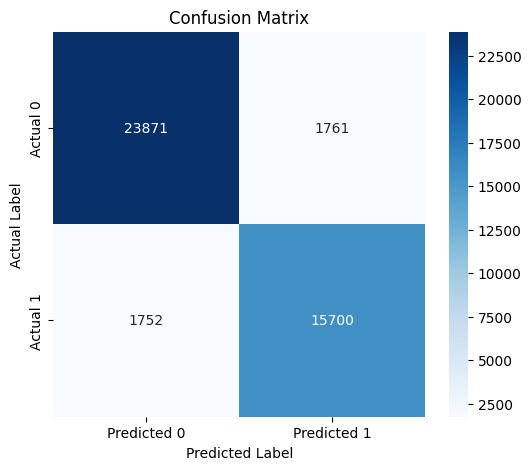

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_true, y_pred_classes)

print(cm)

print(classification_report(y_true, y_pred_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Preparing Submission of Test Results to Kaggle ##

In [76]:
import os

test_dir = '/content/data/test'
test_file_names = os.listdir(test_dir)

# Create a DataFrame for the generator
# It only needs the 'id' column for the generator to know which files to load
test_df = pd.DataFrame({'id': test_file_names})
print(test_df.head())

# Configure the Test Generator
test_datagen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=42
)



                                             id
0  7b868a07959d7c4c164f928c28ae7c74e61a6604.tif
1  2842ed2862f5c26f32896d09acc7ff5611f219b2.tif
2  b537b69496669600e6f9660c213283c1f9930a79.tif
3  b72457cac9627a7af39836a71655ec0f9bc46ee0.tif
4  75dde1bf60f4c244353f9daabfb849dfb2d311ac.tif
Found 57458 validated image filenames.


In [78]:
# The steps value ensures the generator is run until all images are processed
steps = int(np.ceil(test_datagen.n / test_datagen.batch_size))
y_pred_proba = full_model.predict(test_datagen, steps=steps, verbose=1)

# Convert probabilities to binary labels (0 or 1) by rounding
y_pred_labels = (y_pred_proba > 0.5).astype(int).flatten()

file_names_with_ext = test_datagen.filenames

# Extract the submission ID (filename WITHOUT the .tif extension)
submission_ids = [os.path.splitext(f)[0] for f in file_names_with_ext]

submission_df = pd.DataFrame({
    'id': submission_ids,
    'label': y_pred_labels
})

submission_df.to_csv('/content/cancer_submission.csv', index=False)

print(submission_df.head())

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step
                                         id  label
0  7b868a07959d7c4c164f928c28ae7c74e61a6604      1
1  2842ed2862f5c26f32896d09acc7ff5611f219b2      0
2  b537b69496669600e6f9660c213283c1f9930a79      0
3  b72457cac9627a7af39836a71655ec0f9bc46ee0      0
4  75dde1bf60f4c244353f9daabfb849dfb2d311ac      0


# Discussion and Conclusion #

## Learnings and Takeaways ##
- Models without a dropout layer resulted in significant overfitting
-


## Things That Did Not Work as Expected ##

- Initial efforts to conduct hyperparameter search on the entire dataset were not fruitful. So I moved to using a subset of the data for myperparameter tuning.
- I initially was not resetting the keras backend between runs during hyperparameter tuning. I started seeing inconsistent results, and, found the keras documentation recommends calling *tf.keras.backend.clear_session()* between training runs.



## Future Improvements ##
- While Google Colab allowed me to run faster than my laptop, it is not really suitable for this volume of data. Future iterations should explore better platforms
- As a first step of all of my architectures, I trimmed the images to the central 32x32 pixels. I did thins because the documentation indicated only these pixels mattered for the label, but it is possible that including the other portions of the image might results in better performance in cases where the 32 pixel boundary interected a tumor. Future efforts should explore using the entire image.



# Citations #

- Baeldung. (2023). What is the purpose of a feature map in a convolutional neural network | Baeldung on computer science. https://www.baeldung.com/cs/cnn-feature-map
- Cukierski, W. (2018). Histopathologic Cancer detection. Kaggle. https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
- Litjens, G. (2019, April 24). Getting started with Camelyon (Part 1). Geert Litjens. https://geertlitjens.nl/post/getting-started-with-camelyon/
- Minhas, M. S. (2025, March 5). Image data generators in Keras. Towards Data Science. https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400/?gi=1ee1e52e7465
- More, P. (2025, September 2). Outlier detection with the IQR Method: A Complete Guide. Medium. https://medium.com/@morepravin1989/outlier-detection-with-the-iqr-method-a-complete-guide-c0199bbc10bd
- Veeling, B. (2018). Basveeling/PCAM: The Patchcamelyon (PCAM) deep learning classification benchmark. GitHub. https://github.com/basveeling/pcam


